# Experiment 8
In this experiment, the adversarial learning technique is dropped altogether, a single Graph-based auto-encoder is used, using anothoer implementation of the Graph autoencoder, and the without using torch_geometry's implementation

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
df = df.iloc[21600:]
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [4]:
window_size = 100
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 50
train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [5]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 12)
        self.conv2 = GCNLayer(12, 4)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_ReLu_W(num_nodes, k, device)

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(204, 400),
            nn.ReLU(),
            nn.Linear(400, 800),
            nn.ReLU(),
            nn.Linear(800, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

In [6]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 50 # feature size in GCN layers
alpha = 0.1 # hyperparameter for weights of edges
k = 15 # max number of edges for each node
out_channels = 2 # number of process states

In [7]:
Encoder = GEncoder(num_nodes, window_size)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)
AE2 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [8]:
AE1.to(device)
AE2.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=100, out_features=12, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=12, out_features=4, bias=True)
    )
    (A): Graph_ReLu_W()
  )
  (decoder): Sequential(
    (0): Linear(in_features=204, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=800, out_features=5100, bias=True)
  )
)

In [9]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [22]:
features.shape

torch.Size([4096, 100, 51])

In [10]:
# writer = SummaryWriter('runs/GAE_' + f'{epochs}_epochs' + 'only autoencoder')
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        # features = torch.transpose(features, 1, 2)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            # features = torch.transpose(features, 1, 2)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.1809, AE2: 0.1772
Train loss: AE1 0.3739, AE2 0.3688
Epoch: 1 ---> Val loss: AE1 0.1659, AE2: -0.0105
Train loss: AE1 0.2152, AE2 -0.0235
Epoch: 2 ---> Val loss: AE1 0.1577, AE2: -0.0612
Train loss: AE1 0.1630, AE2 -0.0589
Epoch: 3 ---> Val loss: AE1 0.1418, AE2: -0.0754
Train loss: AE1 0.1514, AE2 -0.0788
Epoch: 4 ---> Val loss: AE1 0.1357, AE2: -0.0858
Train loss: AE1 0.1420, AE2 -0.0880
Epoch: 5 ---> Val loss: AE1 0.1563, AE2: -0.1104
Train loss: AE1 0.1425, AE2 -0.0973
Epoch: 6 ---> Val loss: AE1 0.1290, AE2: -0.0956
Train loss: AE1 0.1351, AE2 -0.0982
Epoch: 7 ---> Val loss: AE1 0.1224, AE2: -0.0940
Train loss: AE1 0.1257, AE2 -0.0953
Epoch: 8 ---> Val loss: AE1 0.1233, AE2: -0.0986
Train loss: AE1 0.1274, AE2 -0.0996
Epoch: 9 ---> Val loss: AE1 0.1459, AE2: -0.1219
Train loss: AE1 0.1359, AE2 -0.1091
Epoch: 10 ---> Val loss: AE1 0.1469, AE2: -0.1252
Train loss: AE1 0.1346, AE2 -0.1106
Epoch: 11 ---> Val loss: AE1 0.1356, AE2: -0.1165
Train loss: AE1 

In [44]:
features.shape

torch.Size([4096, 51, 200])

# Testing

In [11]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [12]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [13]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            # batch = torch.transpose(batch, 1, 2)
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [14]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [15]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [16]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [17]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [23]:
len(y_pred)

449819

In [19]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

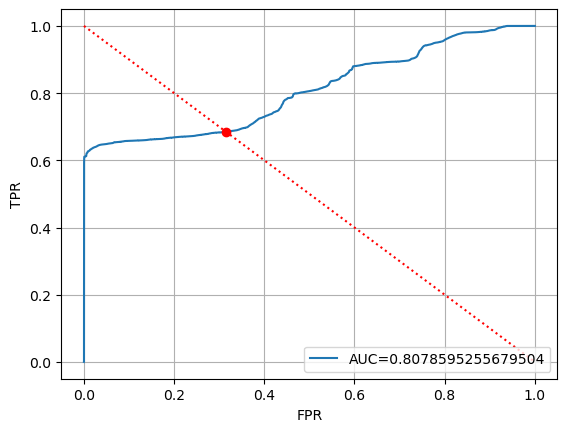

array([5.5964627], dtype=float32)

In [20]:
threshold = ROC(y_test,y_pred)
threshold

best: 13.142857142857142 F1: 0.7561803509670808


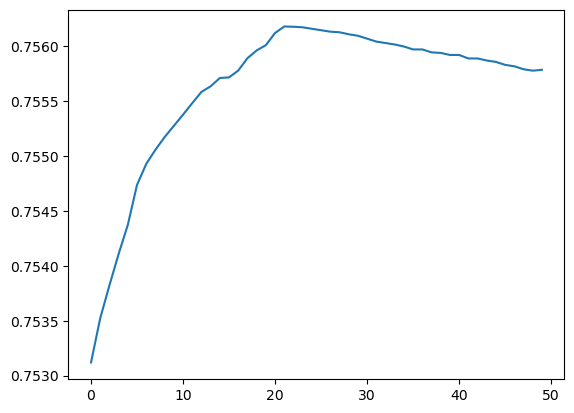

In [22]:
ff = 0
f_history = []
initial_y = 11
best = -1
for inc in np.linspace(0, 5, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

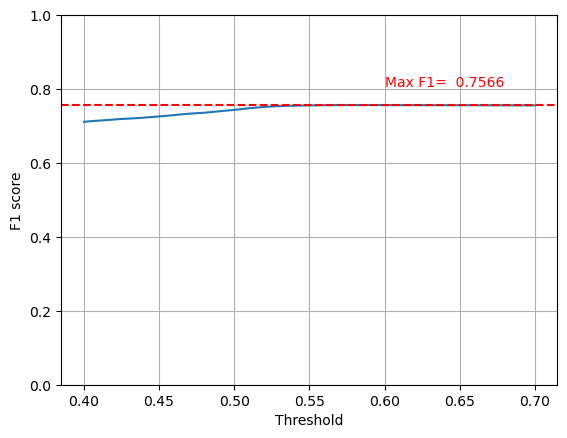

In [36]:
x_vals = 0.4 + np.linspace(0, 0.3, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

# plt.savefig('my_plot.png')

plt.show()

In [33]:
y_pred_int = [1 if (yy > 0.46938775510204084) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.6346748574674437
Recall: 0.49212097484584516
F1 Score: 0.5543804842192309
TP: 30168
TN: 371052
FP: 17365
FN: 31134
